<h1>AI Face Mask Detector, Project Assignment Part-I.</h1>
<h5>COMP 6721 Applied Artificial Intelligence</h5>
<ul>
<li>40155790 - Sivakumaran Malli Janardhanan</li>
<li>40198979 - Saghana Mahesh</li>
<li>40163063 - Shubhang Khattar</li>
</ul>

<hr>
<p>Goal is to to develop a Deep Learning Convolutional Neural Network (CNN) using PyTorch and train it to recognize five different classes:</p>
<ol>
<li>Person without a face mask</li>
<li>Person with a cloth face mask</li>
<li>Person with a surgical mask</li>
<li>Person with a N95 mask</li>
<li>Person with a N95 mask that has a valve.</li>
</ol>

<h5> Importing packages </h5>
<p> All packages to be imported will be declared all together to keep code clean </p>

In [1]:
# Importing libraries
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.nn import functional
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import math
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix , classification_report

<h5>Constants Declaration</h5>
<p> All Constants used below in the project will be declared here.</p>
<p> learning rate = 0.001 </p>
<p> Number of epochs = 30 </p>

In [2]:
# Declaring various constants
dataSet_Path = 'Project_Dataset_2/'
epochs = 30
use_saved_model = False
model_name = "CNN.model"

<h5> Data loading </h5>
<p> The data set for this project has been compiled from various sources </p>

1. https://www.kaggle.com/omkargurav/face-mask-dataset
2. https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset
3. https://www.kaggle.com/sumansid/facemask-dataset
4. https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset
5. https://www.kaggle.com/omkargurav/face-mask-dataset
6. https://humansintheloop.org/resources/datasets/medical-mask-dataset/
7. https://www.shutterstock.com/search/ffp2?number_of_people=1&mreleased=true
8. https://www.gettyimages.ca/photos/ffp2-mask?assettype=image&sort=mostpopular&

We have the following number of images
Cloth_Mask - 435  images
N95 - 402  images
N95_With_Valve - 402  images
No_Mask - 410  images
Surgical - 420  images

We have utilised 20% of the dataset for testing. In the remaining dataset, 80% is used for training and 20% is used for validation.

In [3]:
def data_loader(path,batch,test_data_index,validation_data_index):

    torch.manual_seed(0)
    transformer = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.225, 0.225, 0.225])])

    all_data = ImageFolder(root=path, transform=transformer)

    class_labels_dict = {}
    class_names = all_data.classes
    label_count = 0
    for label_name in all_data.classes:
        class_labels_dict[label_count] = label_name
        label_count += 1

    mask_counts = dict()

    for path,label in all_data.imgs:

        count = mask_counts.get(label,0) + 1
        mask_counts[label] = count

    data_test_size = math.floor(test_data_index*len(all_data))
    data_train_size =  len(all_data) - data_test_size
    data_validation_size = math.floor(validation_data_index * data_train_size)
    data_train_size = data_train_size - data_validation_size

    data_train_loader = DataLoader(all_data,batch_size=batch,pin_memory=True,sampler=torch.randperm(len(all_data))[:data_train_size])
    data_validation_loader = DataLoader(all_data,batch_size=batch,pin_memory=True,sampler=torch.randperm(len(all_data))[data_train_size:data_train_size+data_validation_size])
    data_test_loader = DataLoader(all_data,batch_size=batch,pin_memory=True,sampler=torch.randperm(len(all_data))[(data_train_size+data_validation_size):])

    data = {'0':mask_counts[0], "1":mask_counts[1], '2':mask_counts[2],
            "3":mask_counts[3], "4" : mask_counts[4]}
    courses = list(data.keys())
    values = list(data.values())
    plt.bar(courses, values, color ='maroon',width = 0.4)
    plt.xlabel("Type of classes")
    plt.ylabel("No. of images")
    plt.title("Number of images in for each mask type")
    plt.show()

    for i in class_labels_dict.keys():
        print(i ," : " , class_labels_dict[i],"-",mask_counts[i]," images")

    labels = 'Training', 'Validation', 'Testing'
    sizes = [data_train_size, data_validation_size, data_test_size]
    explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%",
            shadow=True, startangle=90)
    ax1.axis('equal')
    plt.title("Divison of data")
    plt.show()

    print("Total Data set Size: ",len(all_data))
    print("Train Image Size : ",data_train_size)
    print("Validation Image Size : ",data_validation_size)
    print("Test Image Size : ",data_test_size)


    return data_train_loader, data_validation_loader ,data_test_loader, class_labels_dict, class_names

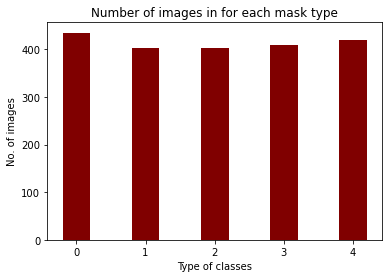

0  :  Cloth_Mask - 435  images
1  :  N95 - 402  images
2  :  N95_With_Valve - 402  images
3  :  No_Mask - 410  images
4  :  Surgical - 420  images


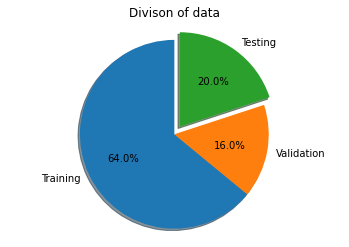

Total Data set Size:  2069
Train Image Size :  1325
Validation Image Size :  331
Test Image Size :  413


In [4]:
data_train_loader, data_validation_loader ,data_test_loader, class_labels_dict, class_names = data_loader(dataSet_Path,32,0.2,0.2)

<h5> Concolution Neural Network </h5>
<p> Here we are passing our training dataset over 6 Convolutional 2D layer with RGB channel and passing through ReLu activation function after every layer. The output channel produced after every 2 layers is passed through MaxPool2d to define the size of the flattened image. </p>

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.convolution_layers =  nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3),stride=(1,1),padding=(1,1)), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),stride=(1,1),padding=(1,1)), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=(1,1)), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),
        )
        self.fully_connected_layers = nn.Sequential(
            nn.Linear(in_features=128*16*16,out_features=50),
            nn.Linear(in_features=50,out_features=5)
        )

    def forward(self,X):
        X = self.convolution_layers(X)
        X =  self.fully_connected_layers(X.reshape(-1,128*16*16))
        return X

<p> Command to check and use "Cuda" if system has a graphic card, else force CPU. </p>

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<p>Check whether a trained model is already saved or not. If present used the saved model, else re-run the training script.</p>

In [17]:
model = CNN().to(device)

if use_saved_model:
    model.load_state_dict(torch.load(model_name),strict=False)

print(model)

CNN(
  (convolution_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected_layers): Sequential(
    (0): Linear(in

<p> Below is the main script which calls the CNN model to train the training dataset. Here we are using 30 epochs for training and a learning rate of 0.001. We are also displaying the training loss, validation loss and accuracy on validation after each and every epoch. </p>

In [8]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
complete_validation_loss_list = []
accuracy_list = []

if not use_saved_model:

    for e in tqdm_notebook(range(epochs) , desc = "Epochs Completed : "):
        model.train()
        loss_training = 0
        for i, (images,labels) in enumerate(data_train_loader):
            outputs = model(images.to(device))
            model.zero_grad()
            loss_training = criterion(outputs,labels.to(device))
            loss_training.backward()
            optimizer.step()

        model.eval()
        loss_validation=0

        correct = 0
        total = 0
        for i, (images,labels) in enumerate(data_validation_loader):
            with torch.no_grad():
                outputs = model(images.to(device))
                total += len(labels)
                _, predicted = torch.max(outputs.data,1)
                correct += (predicted == labels).sum().item()
                loss_validation = criterion(outputs,labels.to(device))
        complete_validation_loss_list.append(loss_validation)
        accuracy = (correct/total)* 100
        accuracy_list.append(accuracy)
        print('*** Epoch : {} *** \n Training Loss : {:.5f} - Validation Loss : {:.5f} - Accuracy on Validation Data : {:.2f}\n'.format(e+1,loss_training,loss_validation , accuracy))

Epochs Completed :   0%|          | 0/30 [00:00<?, ?it/s]

*** Epoch : 1 *** 
 Training Loss : 3.49331 - Validation Loss : 6.95042 - Accuracy on Validation Data : 58.91

*** Epoch : 2 *** 
 Training Loss : 1.19116 - Validation Loss : 3.40814 - Accuracy on Validation Data : 57.70

*** Epoch : 3 *** 
 Training Loss : 0.34328 - Validation Loss : 2.55441 - Accuracy on Validation Data : 56.19

*** Epoch : 4 *** 
 Training Loss : 0.06540 - Validation Loss : 2.48608 - Accuracy on Validation Data : 71.00

*** Epoch : 5 *** 
 Training Loss : 0.03865 - Validation Loss : 1.44650 - Accuracy on Validation Data : 82.48

*** Epoch : 6 *** 
 Training Loss : 1.00045 - Validation Loss : 1.27242 - Accuracy on Validation Data : 83.08

*** Epoch : 7 *** 
 Training Loss : 0.21597 - Validation Loss : 0.54070 - Accuracy on Validation Data : 82.48

*** Epoch : 8 *** 
 Training Loss : 0.11512 - Validation Loss : 0.36220 - Accuracy on Validation Data : 82.18

*** Epoch : 9 *** 
 Training Loss : 0.13522 - Validation Loss : 1.10423 - Accuracy on Validation Data : 84.89

*

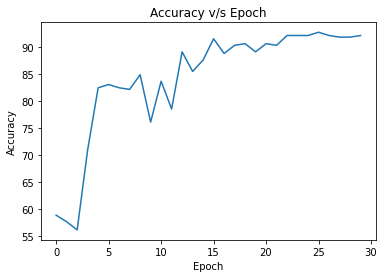

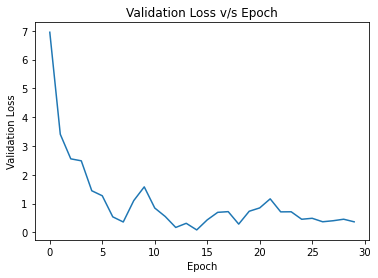

In [15]:
if not use_saved_model:

    torch.save(model.state_dict(), model_name)
    plt.plot(accuracy_list)
    plt.title('Accuracy v/s Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    plt.plot(complete_validation_loss_list)
    plt.title('Validation Loss v/s Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.show()



In [11]:
predicted_labels = []
correct_labels = []
total = 0

correct_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for  i,(images,labels) in enumerate(data_test_loader):
        outputs = model(images.to(device))
        outputs = torch.argmax(functional.softmax(outputs),dim=1)
        if predicted_labels==[]:
            correct_labels=labels[:];
            predicted_labels = outputs[:]

        else:

            correct_labels = torch.hstack([correct_labels,labels])
            predicted_labels = torch.hstack([predicted_labels,outputs])


/var/folders/5s/c7pshfq90w9ccjykz9kg_yfw0000gn/T/ipykernel_65074/1437411016.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.argmax(functional.softmax(outputs),dim=1)
/Users/shubhangkhattar/.conda/envs/JustForFun/lib/python3.8/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<h3>Evaluation</h3>
<p> Based on the above information, plotting a confusion matrix taking 'precision', 'recall', 'f1-score', 'support' into consideration for all 5 types of mask. </p>

                precision    recall  f1-score   support

    Cloth_Mask       0.95      0.87      0.91        99
           N95       0.91      0.95      0.93        77
N95_With_Valve       0.85      0.86      0.86        72
       No_Mask       0.99      1.00      0.99        76
      Surgical       0.90      0.93      0.92        89

      accuracy                           0.92       413
     macro avg       0.92      0.92      0.92       413
  weighted avg       0.92      0.92      0.92       413



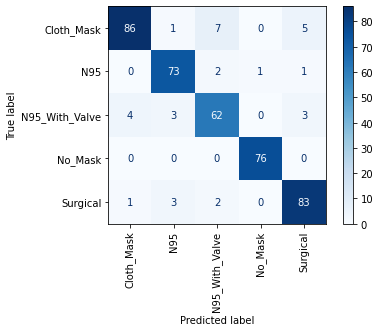

In [12]:
target_names = class_names
labels_names = [0,1,2,3,4]
print(classification_report(correct_labels, predicted_labels,labels=labels_names, target_names=target_names))
cm = confusion_matrix(correct_labels, predicted_labels,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g',xticks_rotation='vertical')
plt.show()